In [199]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [167]:
# Откроем все таблицы из папки data в соответствующие датафреймы
df_category_spends = pd.read_csv('data/category_wise_spends.csv')
df_race_spends = pd.read_csv('data/race_wise_spends.csv')
df_team = pd.read_csv('data/team_info.csv')
df_races = pd.read_csv('data/races_updated.csv')
df_sprint = pd.read_csv('data/sprint_results_updated.csv')
df_results = pd.read_csv('data/results_updated.csv')
df_qualifying = pd.read_csv('data/qualifying_updated.csv')
df_pit = pd.read_csv('data/pit_stops_updated.csv')
df_lap = pd.read_csv('data/lap_times_updated.csv')
df_drivers = pd.read_csv('data/drivers_updated.csv')
df_driver_standings = pd.read_csv('data/driver_standings_updated.csv')
df_constructor_standings = pd.read_csv('data/constructor_standings_updated.csv')
df_constructor_results = pd.read_csv('data/constructor_results_updated.csv')
df_constructors = pd.read_csv('data/constructors_updated.csv')

# Преображение данных


Для начала проведем некоторые манипуляции для интеграции таблиц с сайта f1budgetcup.com с таблицами с kaggle.com

"Соединим" таблицу race_spends по raceId с каггловскими датасетами

In [168]:
# Удалим скобки и года из столбца 'title'
df_race_spends['title'] = df_race_spends['title'].apply(lambda x: re.sub(r'\s*\[.*?\]\s*', '', x))

# Проведем слияние таблиц по колонкам 'title' и 'year'
merged_df = pd.merge(df_race_spends, df_races, left_on=['title', 'year'], right_on=['name', 'year'], how='left')

# Результат слияния, включая новый raceId
df_race_spends = merged_df[['id', 'title', 'sum', 'team_id', 'year', 'raceId']]
df_race_spends

,id,title,sum,team_id,year,raceId
0,19,Japanese Grand Prix,385417,1,2022,1092.0
1,21,Mexico Grand Prix,385417,1,2022,NaN
2,25,Dhabi Grand Prix,385417,1,2022,NaN
3,8,Monaco Grand Prix,385417,1,2022,1080.0
4,17,Italian Grand Prix,770834,1,2022,1089.0
...,...,...,...,...,...,...
403,15,Belgian Grand Prix,683000,10,2023,1110.0
404,20,Qatar Grand Prix,665000,10,2023,1115.0
405,9,Spanish Grand Prix,665000,10,2023,1105.0
406,22,United States Grand Prix,665000,10,2023,1116.0


Заметим, что raceId в некоторых строках отсутствует. Скорее всего это произошло из-за некачественного датасета с сайта f1budgetcup.com, в котором хранились данные по гран-при, которые не проводились в определенные сезоны.

In [172]:
# Удалим отсутствующие данные Nan из столбца 'raceId'
df_race_spends = df_race_spends.dropna(subset=['raceId'])

# Заменим возможные NaN значения в столбце 'raceId' на -1 и переведем значения столбца 'raceId' в integer
df_race_spends['raceId'] = df_race_spends['raceId'].fillna(-1).astype(int)

## Обновим Id команд в таблицах с сайта f1budgetcup.com по датасетам из каггла

In [170]:
# Создадим словарь с именами команд из team_info, которые нужно преобразовать в имена команд из constructors 
rename_dict = {
    'Visa Cash App RB F1 Team': 'AlphaTauri',
    'Red Bull': 'Red Bull',
    'Williams': 'Williams',
    'Stake F1 Team Kick Sauber': 'Sauber',
    'Mc Laren': 'McLaren',
    'Mercedes': 'Mercedes',
    'Haas F1 Team': 'Haas F1 Team',
    'Ferrari': 'Ferrari',
    'Alpine': 'Alpine F1 Team'
}

# Переименуем строки в столбце 'team_name' с использованием словаря
df_team['team_name'] = df_team['team_name'].replace(rename_dict)

# Переименуем столбец team_name в name для удобства
df_team = df_team.rename(columns={'team_name': 'name'})

# Используем объединение по столбцу 'name'
df_team = df_team.merge(df_constructors[['name', 'constructorId']], on='name', how='left')

In [171]:
# Объединим оставшиеся таблицы с сайта f1budgetcup.com по столбцу 'team_id'
df_category_spends = df_category_spends.merge(df_team[['team_id', 'constructorId']], on='team_id', how='left')
df_race_spends = df_race_spends.merge(df_team[['team_id', 'constructorId']], on='team_id', how='left')

# Удалим  столбец 'team_id' из всех таблиц
df_category_spends = df_category_spends.drop(columns=['team_id'])
df_race_spends = df_race_spends.drop(columns=['team_id'])
df_team = df_team.drop(columns=['team_id'])

Теперь, когда наши датасеты приведены в порядок, можно приступать к их анализу

## Информация о датасетах

Краткая сводка по информации, содержащейся в датафреймах:

df_category_spends - траты команд формулы 1 по годам на конкретные категории
df_race_spends - траты команд формулы 1 по годам на каждое гран-при
df_team - информация о командах и их общим бюджетам по годам 
df_races - информация о проведенных гонках за исследуемые года
df_sprint - информация о проведенных спринтах перед гран-при 
df_results - информация о результатах гонщиков на каждом гран-при 
df_qualifying - информация о результатах квалификации гонщиков перед гран-при
df_pit - информация о пит-стопах
df_lap - информация по каждому кругу на гран-при
df_drivers - список гонщиков формулы 1
df_driver_standings - результаты гонщиков формулы 1 по сезонам
df_constructor_standings - результаты команд формулы 1 по сезонам 
df_constructor_results - результаты команд по каждому гран-при
df_constructors - список команд формулы 1

# Графики

#### Трекинг результатов по гонкам:

###### График финишных позиций по гонкам Линейный график с гонками по оси X и финишными позициями по оси Y для выбранных водителей.

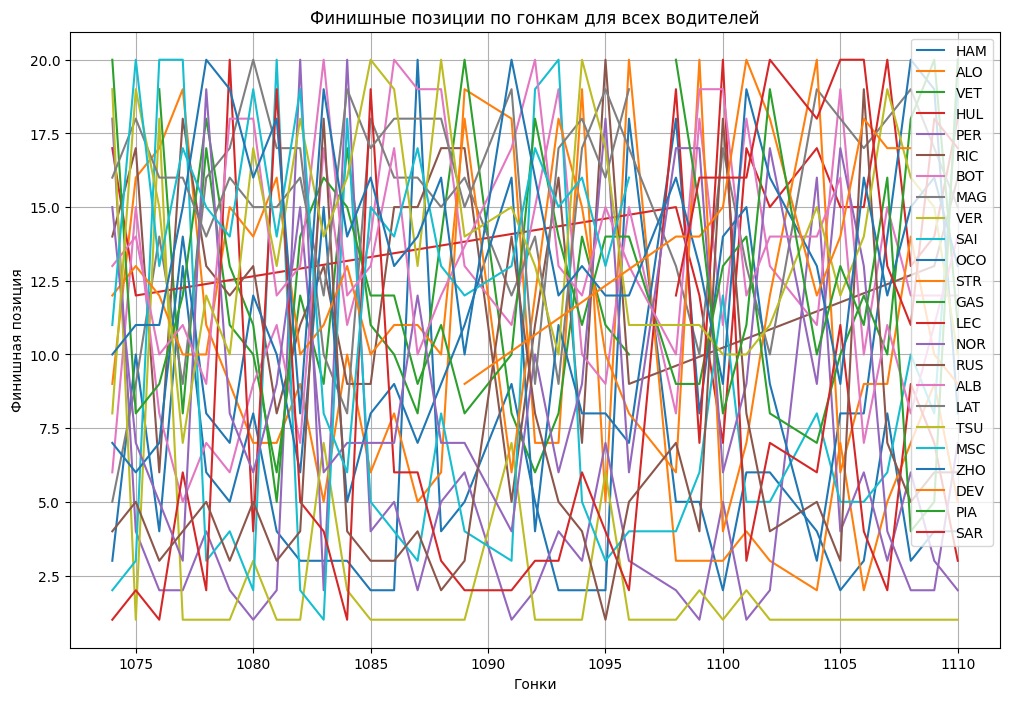

In [188]:
# Объедим df_results с df_drivers по столбцу driverId
df_merged = pd.merge(df_results, df_drivers, on='driverId')

# Сгруппируем данные по гонкам и водителям и проведем расчет средней финишной позиции
avg_finish_positions = df_merged.groupby(['raceId', 'driverId'])['positionOrder'].mean().reset_index()

# Создание графика
plt.figure(figsize=(12, 8))

# Построение линии для каждого водителя
for driverId, group in avg_finish_positions.groupby('driverId'):
    driver_name = df_drivers.loc[df_drivers['driverId'] == driverId, 'code'].values[0]
    plt.plot(group['raceId'], group['positionOrder'], label=driver_name)

plt.title('Финишные позиции по гонкам для всех водителей')
plt.xlabel('Гонки')
plt.ylabel('Финишная позиция')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

###### Распределение позиций на старте и на финише. Скаттерплот, где каждая точка показывает стартовую и финишную позицию водителя в каждой гонке.

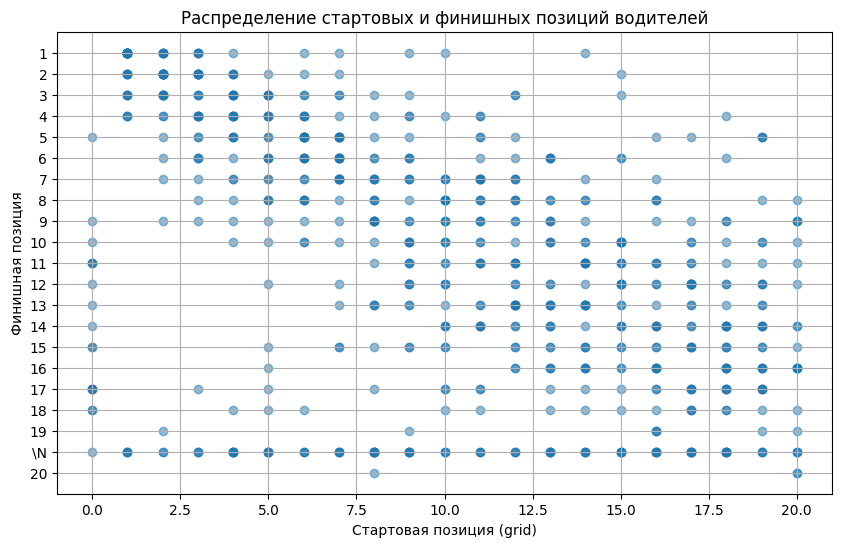

In [183]:
plt.figure(figsize=(10, 6))
plt.scatter(df_results['grid'], df_results['position'], alpha=0.5)
plt.title('Распределение стартовых и финишных позиций водителей')
plt.xlabel('Стартовая позиция (grid)')
plt.ylabel('Финишная позиция')
plt.grid(True)
plt.gca().invert_yaxis()  # Инвертирование оси Y для соответствия порядку финишных позиций
plt.show()

#### Анализ быстрейших кругов:

###### График скоростей самых быстрых кругов. Столбчатая диаграмма, показывающая среднюю скорость самого быстрого круга каждого водителя или команды в течение сезона.

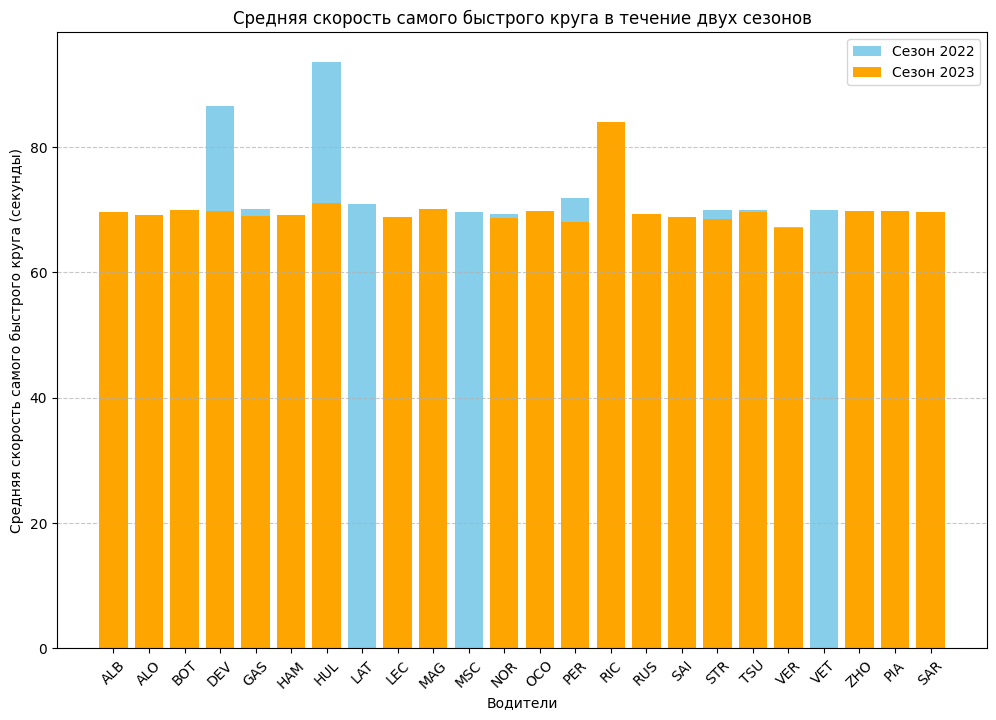

In [197]:
# Объединим df_lap с df_drivers по столбцу driverId
df_merged = pd.merge(df_lap, df_drivers, on='driverId')

# Разделим данные по сезонам
season_2022_laps = df_merged[(df_merged['raceId'] >= 1074) & (df_merged['raceId'] <= 1096)]
season_2023_laps = df_merged[(df_merged['raceId'] >= 1098) & (df_merged['raceId'] <= 1120)]

# Найдем самый быстрый круг для каждого водителя в сезонах
fastest_laps_2022 = season_2022_laps.groupby(['driverId', 'code'])['milliseconds'].min().reset_index()
fastest_laps_2023 = season_2023_laps.groupby(['driverId', 'code'])['milliseconds'].min().reset_index()

# Расчет средней скорости самого быстрого круга для каждого водителя в течение сезонов
average_fastest_lap_speeds_2022 = fastest_laps_2022.groupby('code')['milliseconds'].mean() / 1000  # Перевод в секунды
average_fastest_lap_speeds_2023 = fastest_laps_2023.groupby('code')['milliseconds'].mean() / 1000  # Перевод в секунды

# Создание столбчатой диаграммы
plt.figure(figsize=(12, 8))

# Построим данные для сезона 2022
plt.bar(average_fastest_lap_speeds_2022.index, average_fastest_lap_speeds_2022.values, color='skyblue', label='Сезон 2022')

# Построим данные для сезона 2023
plt.bar(average_fastest_lap_speeds_2023.index, average_fastest_lap_speeds_2023.values, color='orange', label='Сезон 2023')

plt.title('Средняя скорость самого быстрого круга в течение двух сезонов')
plt.xlabel('Водители')
plt.ylabel('Средняя скорость самого быстрого круга (секунды)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Очки и статистика по водителям:

###### Общие очки по сезонам. График, показывающий, как каждый водитель набирал очки по сезонам

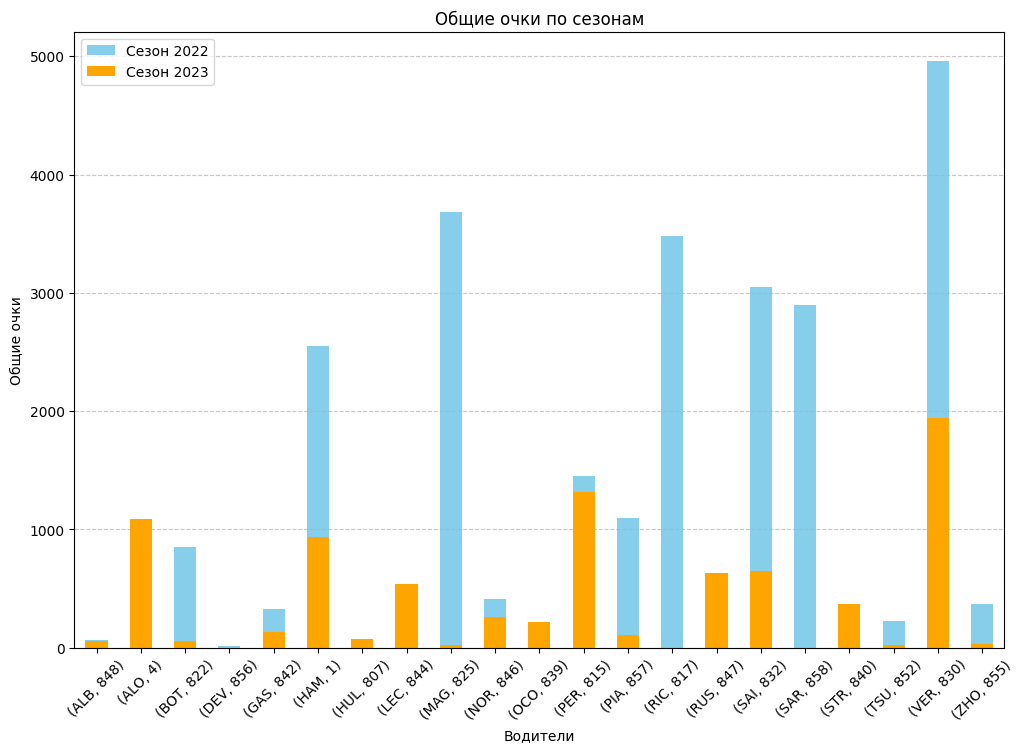

In [195]:
# Объединим df_driver_standings с df_drivers по столбцу driverId
df_merged = pd.merge(df_driver_standings, df_drivers, on='driverId')

# Разделим данные по сезонам
season_2022 = df_merged[(df_merged['raceId'] >= 1074) & (df_merged['raceId'] <= 1096)]
season_2023 = df_merged[(df_merged['raceId'] >= 1098) & (df_merged['raceId'] <= 1120)]

# Рассчет общих очков каждого водителя по сезонам
total_points_2022 = season_2022.groupby(['code', 'driverId'])['points'].sum()
total_points_2023 = season_2023.groupby(['code', 'driverId'])['points'].sum()

# Создание графика
plt.figure(figsize=(12, 8))
total_points_2022.plot(kind='bar', color='skyblue', label='Сезон 2022')
total_points_2023.plot(kind='bar', color='orange', label='Сезон 2023')

plt.title('Общие очки по сезонам')
plt.xlabel('Водители')
plt.ylabel('Общие очки')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

###### Тепловая карта результатов водителя, где строки – это водители, столбцы – гонки, а цвета отражают набранные очки.

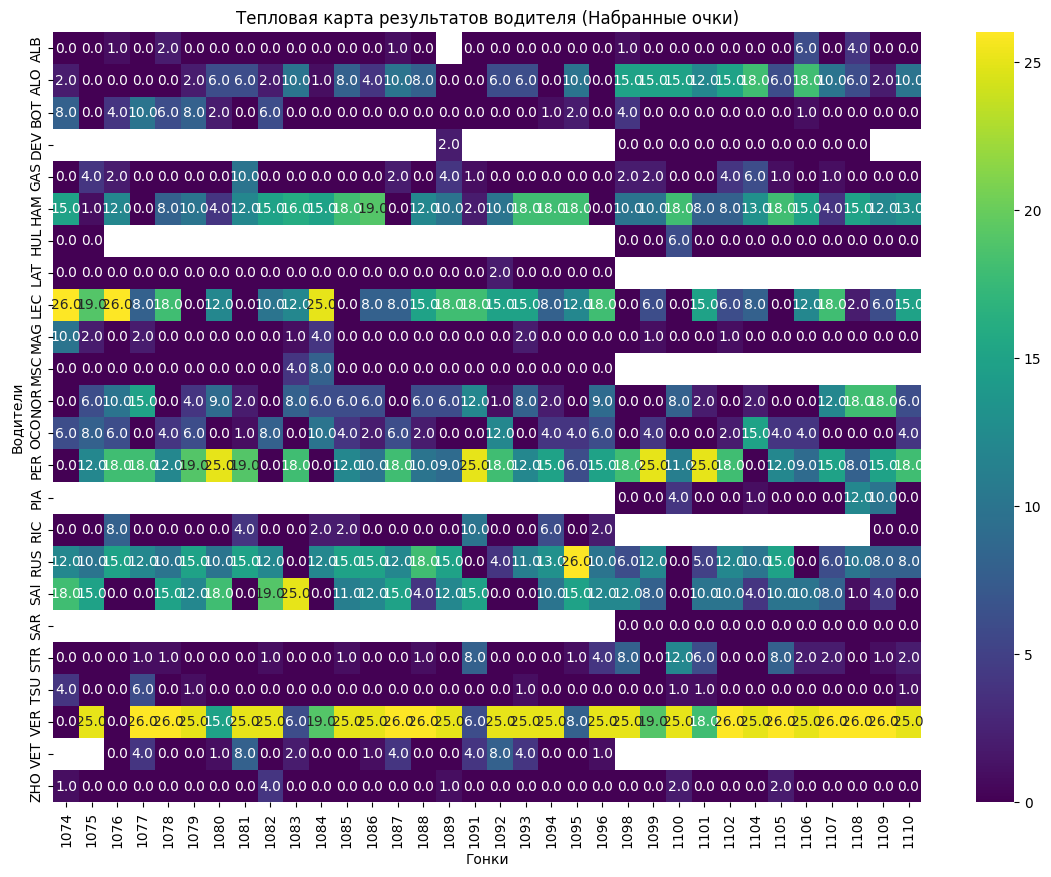

In [204]:
# Объединение df_results с df_drivers по столбцу driverId
df_merged = pd.merge(df_results, df_drivers, on='driverId')

# Создание сводной таблицы для набранных очков
pivot_table_points = df_merged.pivot_table(index='code', columns='raceId', values='points')

# Создание тепловой карты для набранных очков
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table_points, cmap='viridis', annot=True, fmt=".1f", cbar=True)
plt.title('Тепловая карта результатов водителя (Набранные очки)')
plt.xlabel('Гонки')
plt.ylabel('Водители')
plt.show()

#### Сравнение команд (конструкторов):

###### График суммарных результатов команд - столбчатая диаграмма, показывающая суммарные очки каждой команды в разрезе сезонов.

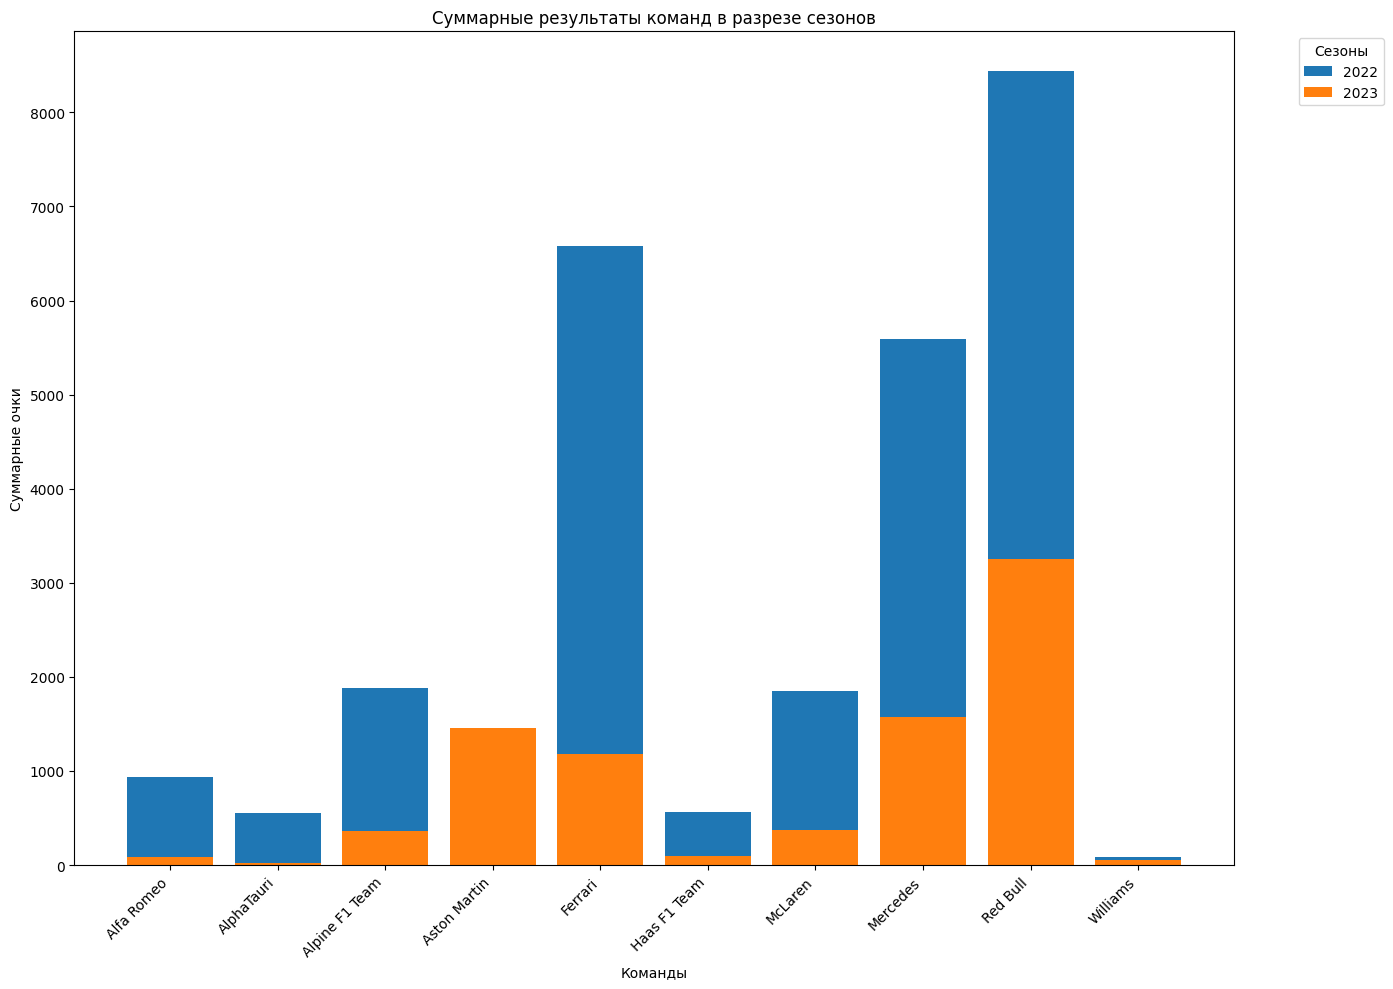

In [210]:
# Объединение df_constructor_standings с df_constructors по столбцу constructorId
df_merged_constructor = pd.merge(df_constructor_standings, df_constructors, on='constructorId')

# Разделим данные по сезонам
season_2022 = df_merged_constructor[(df_merged_constructor['raceId'] >= 1074) & (df_merged_constructor['raceId'] <= 1096)]
season_2023 = df_merged_constructor[(df_merged_constructor['raceId'] >= 1098) & (df_merged_constructor['raceId'] <= 1120)]

# Создание столбчатой диаграммы суммарных результатов команд в разрезе сезонов
plt.figure(figsize=(14, 10))

# Группировка данных по сезонам и командам и расчет суммы очков
pivot_table_2022 = season_2022.pivot_table(index='name', values='points', aggfunc='sum')
pivot_table_2023 = season_2023.pivot_table(index='name', values='points', aggfunc='sum')

# Создание столбчатой диаграммы для каждого сезона
plt.bar(pivot_table_2022.index, pivot_table_2022['points'], label='2022')
plt.bar(pivot_table_2023.index, pivot_table_2023['points'], label='2023')

plt.title('Суммарные результаты команд в разрезе сезонов')
plt.xlabel('Команды')
plt.ylabel('Суммарные очки')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Сезоны', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Машинное обучение

На основе данных о бюджетах команд и их результатах в гонках можно сформулировать несколько интересных задач машинного обучения, но я выберу одну для анализа.

##### Прогнозирование результатов гонок:

Задача: Создать модель, которая может прогнозировать позиции, которые займут команды или водители в гонках, на основе их бюджета и предыдущих результатов.

Тип модели: Регрессия или классификация (если прогнозируемые позиции категоризировать).

Ценность: Понять влияние финансовых ресурсов команд на их успех в гонках.

## Гипотезы

Можно сформулировать несколько гипотез, которые модель машинного обучения поможет подтвердить или опровергнуть.

##### Гипотеза о влиянии бюджета на результаты:

Формулировка: Больший бюджет команды коррелирует с лучшими результатами в гонках.

Цель проверки: Определить, существует ли статистически значимая связь между размером бюджета команды и их местами на финише.

##### Гипотеза о важности предыдущих результатов:

Формулировка: Предыдущие результаты команды являются хорошим предиктором их будущих достижений.

Цель проверки: Проверить, насколько предыдущие достижения влияют на результаты последующих гонок.

##### Гипотеза о влиянии изменений бюджета:

Формулировка: Изменения в бюджете команды от года к году влияют на изменения в их гонках.

Цель проверки: Анализировать, приводит ли увеличение или уменьшение бюджета к соответствующим улучшениям или ухудшениям в результатах.

##### Гипотеза о влиянии бюджета на стабильность результатов:

Формулировка: Команды с большим бюджетом демонстрируют более стабильные результаты на протяжении сезона.

Цель проверки: Изучить, минимизирует ли высокий бюджет колебания в производительности между разными гонками.